# Question Frequency and Distribution Metrics

## **Introduction**

This notebook aims to analyze sales call transcripts to extract key metrics that help assess salesperson performance and customer engagement. The metrics calculated include:

1. **Total Number of Questions**
2. **Questions per Minute**
3. **First Question Timing**
4. **Normalized Entropy**
5. **Gini Coefficient**
6. **Customer Talk Ratio**
7. **Average Time Between Questions (Normalized)**

These metrics provide insights into the frequency and distribution of questions asked by the salesperson, as well as the balance of conversation between the salesperson and the customer.

---

## **1. Data Preparation**

First, we'll install the transformers, import the necessary libraries, and load the transcript data into a pandas DataFrame.

### **Installation and Imports**

In [ ]:
# Install models and ML framework
! pip install transformers datasets torch

# Install data manipulation and visualization tools
! pip install pandas matplotlib

import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('shahrukhx01/question-vs-statement-classifier')
model = AutoModelForSequenceClassification.from_pretrained('shahrukhx01/question-vs-statement-classifier')

### **Loading the Data**

Replace the sample data with your actual transcript data by reading from a CSV file.

In [31]:
# Load the transcript data from a CSV file
df = pd.read_csv('sample.csv')

# Create a new column in the DataFrame to store the classification results
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
df["Is Question"] = df["Transcript"].apply(lambda x: False if classifier(x)[0]["label"] == "LABEL_0" else True)

# Display the first few rows of the DataFrame
df.head()

,Speaker,Email,Transcript,Start Time,End Time,Is Question
0,Matthew Lopez,NaN,Hey Joshua.,0:58.360,0:59.096,False
1,Matthew Lopez,NaN,How are you?,0:59.128,0:59.996,True
2,Joshua Lara,NaN,Hey how's it going?,1:00.178,1:01.500,True
3,Matthew Lopez,NaN,Good.,1:01.650,1:02.396,False
4,Matthew Lopez,NaN,How about yourself?,1:02.578,1:03.804,True


### **Time Conversion Function**

We need to convert the time strings to total seconds for calculations.

In [32]:
# Function to convert time strings to seconds
def time_to_seconds(time_str):
    minutes, seconds = time_str.split(':')
    return int(minutes) * 60 + float(seconds)

# Apply time conversion
df['Start Seconds'] = df['Start Time'].apply(time_to_seconds)
df['End Seconds'] = df['End Time'].apply(time_to_seconds)

df.head()

,Speaker,Email,Transcript,Start Time,End Time,Is Question,Start Seconds,End Seconds
0,Matthew Lopez,NaN,Hey Joshua.,0:58.360,0:59.096,False,58.360,59.096
1,Matthew Lopez,NaN,How are you?,0:59.128,0:59.996,True,59.128,59.996
2,Joshua Lara,NaN,Hey how's it going?,1:00.178,1:01.500,True,60.178,61.500
3,Matthew Lopez,NaN,Good.,1:01.650,1:02.396,False,61.650,62.396
4,Matthew Lopez,NaN,How about yourself?,1:02.578,1:03.804,True,62.578,63.804


### **Identifying Speakers**
Identify who are the account executives and who are the clients.

In [33]:
account_executives = ["Shawn Henderson", "Matthew Lopez"] # List of account executives
df["Is Account Executive"] = df["Speaker"].apply(lambda x: True if x in account_executives else False)

df.head()

,Speaker,Email,Transcript,Start Time,End Time,Is Question,Start Seconds,End Seconds,Is Account Executive
0,Matthew Lopez,NaN,Hey Joshua.,0:58.360,0:59.096,False,58.360,59.096,True
1,Matthew Lopez,NaN,How are you?,0:59.128,0:59.996,True,59.128,59.996,True
2,Joshua Lara,NaN,Hey how's it going?,1:00.178,1:01.500,True,60.178,61.500,False
3,Matthew Lopez,NaN,Good.,1:01.650,1:02.396,False,61.650,62.396,True
4,Matthew Lopez,NaN,How about yourself?,1:02.578,1:03.804,True,62.578,63.804,True


### **Filtering Data by Speaker**

Separate the DataFrame into salesperson and customer DataFrames.

In [50]:
# Filter salesperson's utterances
ae_df = df[(df['Is Account Executive'] & df['Is Question'])].copy()
customer_df = df[(~df['Is Account Executive'] & df['Is Question'])].copy()

,Speaker,Email,Transcript,Start Time,End Time,Is Question,Start Seconds,End Seconds,Is Account Executive
2,Joshua Lara,NaN,Hey how's it going?,1:00.178,1:01.500,True,60.178,61.5,False
235,Joshua Lara,NaN,So I guess in terms of what services you would...,21:00.590,21:08.400,True,1260.590,1268.4,False


---

## **2. Calculating Metrics**

### **2.1 Total Number of Questions**

**Purpose**: Basic measure of engagement.

**Calculation**: Sum of the 'Is Question?' column for the salesperson's entries.

In [35]:
# Total Number of Questions
total_questions = ae_df['Is Question'].sum()
print("Total Number of Questions:", total_questions)

Total Number of Questions: 28


### **2.2 Questions per Minute**

**Purpose**: Normalizes total questions by call length.

**Calculation**: Total questions divided by the call duration in minutes.

In [36]:
# Calculate total call duration in seconds
call_start = df['Start Seconds'].min()
call_end = df['End Seconds'].max()
call_duration_seconds = call_end - call_start
call_duration_minutes = call_duration_seconds / 60

# Questions per Minute
questions_per_minute = total_questions / call_duration_minutes if call_duration_minutes > 0 else 0
print("Questions per Minute:", round(questions_per_minute, 2))

Questions per Minute: 1.03


### **2.3 First Question Timing**

**Purpose**: Measures how quickly the salesperson engages the customer.

**Calculation**: Time of the first question as a percentage of the total call duration.

In [37]:
# First Question Timing
first_question_time = ae_df[ae_df['Is Question'] == True]['Start Seconds'].min()
if not np.isnan(first_question_time):
    first_question_timing = ((first_question_time - call_start) / call_duration_seconds) * 100
    print("First Question Timing (% of Call Duration):", round(first_question_timing, 2))
else:
    print("First Question Timing (% of Call Duration): No questions asked")

First Question Timing (% of Call Duration): 0.05


### **2.4 Normalized Entropy**

**Purpose**: Primary metric for evenness of distribution.

**Calculation**:

1. Divide the call into equal segments.
2. Count the number of questions in each segment.
3. Calculate the entropy and normalize it.

In [38]:
# Number of segments
num_segments = 10
segment_duration = call_duration_seconds / num_segments

# Initialize question counts per segment
questions_per_segment = [0] * num_segments

# Assign each question to a segment
for index, row in ae_df[ae_df['Is Question'] == True].iterrows():
    time_since_start = row['Start Seconds'] - call_start
    segment_index = int(time_since_start // segment_duration)
    if segment_index >= num_segments:
        segment_index = num_segments - 1  # Handle edge case
    questions_per_segment[segment_index] += 1

# Calculate probabilities
total_questions_in_segments = sum(questions_per_segment)
if total_questions_in_segments > 0:
    probabilities = [q / total_questions_in_segments for q in questions_per_segment]
    # Calculate entropy
    entropy = -sum([p * np.log2(p) for p in probabilities if p > 0])
    # Normalize entropy
    max_entropy = np.log2(num_segments)
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    print("Normalized Entropy:", round(normalized_entropy, 2))
else:
    print("Normalized Entropy: No questions asked")

Normalized Entropy: 0.69


### **2.5 Gini Coefficient**

**Purpose**: Secondary metric to assess inequality.

**Calculation**: Using the Gini coefficient formula on the distribution of questions per segment.

In [39]:
# Gini Coefficient Function
def gini_coefficient(x):
    x = np.array(x, dtype=np.float64)  # Ensure x is of type float
    if np.amin(x) < 0:
        x -= np.amin(x)  # Values cannot be negative
    x += 0.0000001  # Avoid division by zero
    x = np.sort(x)
    n = x.size
    index = np.arange(1, n + 1)
    gini = ((np.sum((2 * index - n - 1) * x)) / (n * np.sum(x)))
    return gini

# Calculate Gini Coefficient
if total_questions_in_segments > 0:
    gini = gini_coefficient(questions_per_segment)
    print("Gini Coefficient:", round(gini, 2))
else:
    print("Gini Coefficient: No questions asked")

Gini Coefficient: 0.61


### **2.6 Customer Talk Ratio**

**Purpose**: Measures the balance of conversation.

**Calculation**: Percentage of total talk time attributed to the customer.

In [40]:
# Calculate total speaking time for salesperson and customer
salesperson_talk_time = ae_df['End Seconds'].sum() - ae_df['Start Seconds'].sum()
customer_talk_time = customer_df['End Seconds'].sum() - customer_df['Start Seconds'].sum()

total_talk_time = salesperson_talk_time + customer_talk_time
if total_talk_time > 0:
    customer_talk_ratio = (customer_talk_time / total_talk_time) * 100
    print("Customer Talk Ratio (%):", round(customer_talk_ratio, 2))
else:
    print("Customer Talk Ratio (%): No talk time recorded")

Customer Talk Ratio (%): 10.66


### **2.7 Average Time Between Questions (Normalized)**

**Purpose**: Assesses pacing of questions.

**Calculation**: Average time between questions as a percentage of the total call duration.

In [41]:
# Average Time Between Questions (Normalized)
question_times = ae_df[ae_df['Is Question'] == True]['Start Seconds'].tolist()
if len(question_times) > 1:
    intervals = [t2 - t1 for t1, t2 in zip(question_times[:-1], question_times[1:])]
    average_interval = np.mean(intervals)
    normalized_average_interval = (average_interval / call_duration_seconds) * 100
    print("Average Time Between Questions (Normalized % of Call Duration):", round(normalized_average_interval, 2))
elif len(question_times) == 1:
    print("Average Time Between Questions (Normalized % of Call Duration): Only one question asked")
else:
    print("Average Time Between Questions (Normalized % of Call Duration): No questions asked")

Average Time Between Questions (Normalized % of Call Duration): 3.07



---

## **3. Summary of Metrics**

Compile all the calculated metrics into a summary for easy reference.

In [42]:
# Create a summary dictionary
metrics_summary = {
    'Total Number of Questions': total_questions,
    'Questions per Minute': round(questions_per_minute, 2),
    'First Question Timing (% of Call Duration)': round(first_question_timing, 2) if not np.isnan(first_question_time) else 'No questions asked',
    'Normalized Entropy': round(normalized_entropy, 2) if total_questions_in_segments > 0 else 'No questions asked',
    'Gini Coefficient': round(gini, 2) if total_questions_in_segments > 0 else 'No questions asked',
    'Customer Talk Ratio (%)': round(customer_talk_ratio, 2) if total_talk_time > 0 else 'No talk time recorded',
    'Average Time Between Questions (Normalized % of Call Duration)': round(normalized_average_interval, 2) if len(question_times) > 1 else 'Not applicable'
}

# Display the summary
for metric, value in metrics_summary.items():
    print(f"{metric}: {value}")

Total Number of Questions: 28
Questions per Minute: 1.03
First Question Timing (% of Call Duration): 0.05
Normalized Entropy: 0.69
Gini Coefficient: 0.61
Customer Talk Ratio (%): 10.66
Average Time Between Questions (Normalized % of Call Duration): 3.07



---

## **4. Interpretation of Results**

Based on the calculated metrics, you can interpret the salesperson's performance and customer engagement during the call.

- **Total Number of Questions**: Indicates how actively the salesperson is engaging the customer by asking questions.
- **Questions per Minute**: Normalizes the question count by call length; higher values suggest more frequent engagement.
- **First Question Timing**: Early questioning can help in building rapport and understanding customer needs promptly.
- **Normalized Entropy**: Values closer to 1 suggest that questions are evenly distributed throughout the call, maintaining consistent engagement.
- **Gini Coefficient**: Lower values indicate a more equal distribution of questions; higher values suggest clustering.
- **Customer Talk Ratio**: A higher percentage means the customer is contributing more to the conversation, which is often positive in sales contexts.
- **Average Time Between Questions (Normalized)**: Helps assess if questions are too clustered (low percentage) or too sparse (high percentage).

**Table: Metrics, Sample Values, and Interpretations**

| Metric                                      | Sample Value(s)              | Interpretation                                                                                                                                                                                                                 |
|---------------------------------------------|------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Total Number of Questions**               | **5**, **15**                | - **5**: Salesperson asked few questions; may indicate low engagement.<br>- **15**: Salesperson asked many questions; suggests high engagement.                                                                                |
| **Questions per Minute**                    | **0.5**, **3.0**             | - **0.5**: Low frequency of questions; possible missed opportunities to engage.<br>- **3.0**: High frequency; salesperson is actively engaging the customer.                                                                   |
| **First Question Timing (% of Call Duration)** | **5%**, **30%**            | - **5%**: Salesperson asked the first question early; promotes early engagement.<br>- **30%**: Delay in asking first question; potential missed opportunity for early rapport building.                                        |
| **Normalized Entropy**                      | **0.2**, **0.9**             | - **0.2**: Low entropy; questions are unevenly distributed (clustered in certain segments). Indicates that the questions are clustered in certain parts of the call, leading to periods of low engagement elsewhere.<br>- **0.9**: High entropy; questions are evenly distributed throughout the call, maintaining consistent engagement. Shows that questions are evenly distributed throughout the call, helping to maintain consistent customer engagement.            |
| **Gini Coefficient**                        | **0.1**, **0.6**             | - **0.1**: Low inequality; questions are evenly spread across the call. Reflects a very equal distribution of questions across the call segments, which is positive for maintaining engagement.<br>- **0.6**: High inequality; questions are concentrated in a few segments, leading to potential disengagement in other parts of the call. Suggests significant inequality in question distribution, with questions likely clustered in specific segments, potentially leading to disengagement during other parts.         |
| **Customer Talk Ratio (%)**                 | **25%**, **65%**             | - **25%**: Customer speaks less; salesperson may be dominating the conversation.<br>- **65%**: Customer speaks more; indicates a customer-centric approach, allowing the customer to express needs and preferences.            |
| **Average Time Between Questions (Normalized % of Call Duration)** | **10%**, **40%** | - **10%**: Questions are frequent and closely spaced; maintains high engagement.<br>- **40%**: Longer gaps between questions; possible periods of low engagement or missed opportunities to probe further. |


---

## **5. Visualizing the Distribution of Questions**

(Optional) You can create visualizations to better understand the distribution of questions throughout the call.

### **Bar Chart of Questions per Segment**

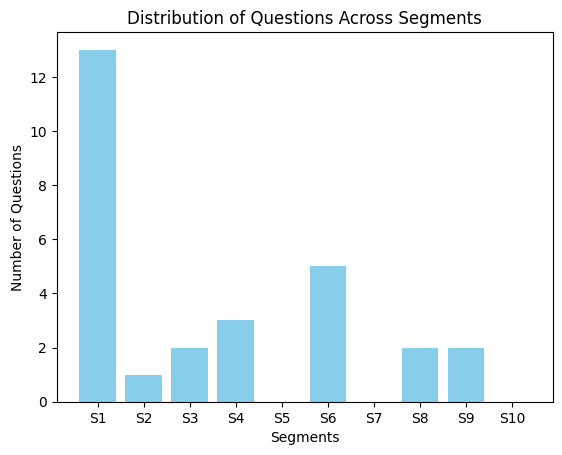

In [45]:
import matplotlib.pyplot as plt

# Bar chart of questions per segment
segments = [f"S{i+1}" for i in range(num_segments)]

plt.bar(segments, questions_per_segment, color='skyblue')
plt.xlabel('Segments')
plt.ylabel('Number of Questions')
plt.title('Distribution of Questions Across Segments')
plt.show()


### **Pie Chart of Customer vs. Salesperson Talk Time**

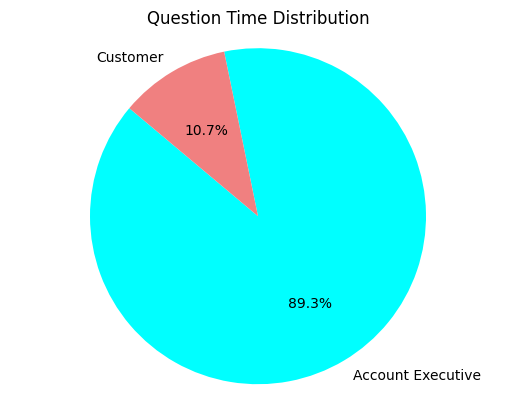

In [51]:
# Pie chart of talk time
talk_times = [salesperson_talk_time, customer_talk_time]
labels = ['Account Executive', 'Customer']
colors = ['aqua', 'lightcoral']

plt.pie(talk_times, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Question Time Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


---

## **6. Conclusion**

This notebook provides a framework for analyzing sales call transcripts to extract meaningful metrics that reflect the salesperson's engagement strategies and the dynamics of the conversation. By regularly monitoring these metrics, sales teams can identify areas for improvement and enhance their interactions with customers.